In [1]:
import cv2
import os
import numpy as np
import matplotlib.pylab as plt
import keras.utils.vis_utils as vutil
from IPython.display import SVG
import tensorflow as tf
import keras.models as models
from keras.optimizers import SGD
from imgaug import augmenters as iaa
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Conv2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import numpy as np
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input
import matplotlib.animation as animation
%matplotlib nbagg

FRAME_H =  70
FRAME_W = 180

STEER_MIDPT = 1500.
STEER_UPPER = 2000.
STEER_LOWER = 1000.

Using TensorFlow backend.


# Predict stearing angle

In [263]:
model.load_weights('weights.hdf5')

In [264]:
def draw_steer(image, steer, color):
    center = (image.shape[1]/2, image.shape[0]/2)
    offset = (image.shape[1]/2 + int(steer*image.shape[1]/2), image.shape[0]/2)
    
    cv2.arrowedLine(image, center, offset, color=color, thickness=1, tipLength=0.4)
    
    return image

In [265]:
generator = BatchGenerator(['demo'], 1, shuffle=False, terminate=True, jitter=False).get_gen()

<IPython.core.display.Javascript object>


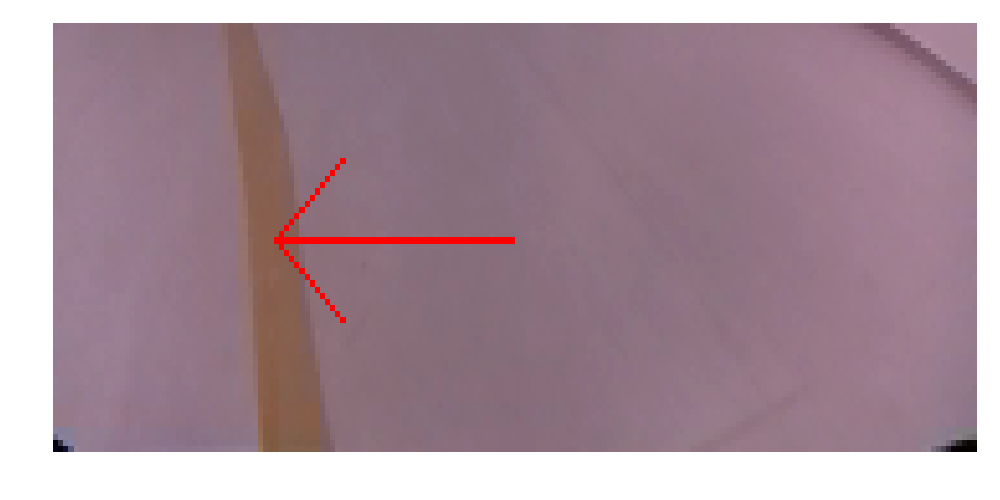

In [267]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=8, metadata=dict(artist='Me'), bitrate=1800)

fig = plt.figure(figsize=(8,4))

image = generator.next()[0][0]
im = plt.imshow(image, animated=True, aspect = 'normal')
plt.axis('off')

def updatefig(*args):
    example = generator.next()

    image = example[0][0].astype('uint8')[:,:,::-1].copy()
    steer = example[1][0][0]
    draw_steer(image, steer, (255,0,0))
    
    #net_inp = np.expand_dims(normalize(image), 0)
    #net_out = model.predict(net_inp)[0][0]
    #draw_steer(image, net_out, (0,255,0))
    
    im.set_array(cv2.flip(image, 1).astype('uint8'))
    return im,

plt.tight_layout()
ani = animation.FuncAnimation(fig, updatefig, interval=200, blit=True, save_count=20000) 
#ani.save('im.mp4', writer=writer)
plt.show()

# Train the network

In [198]:
early_stop  = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, mode='min', verbose=1)
checkpoint  = ModelCheckpoint('weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)
tensorboard = TensorBoard(log_dir='../logs/', histogram_freq=0, write_graph=True, write_images=False)

batch_num = 8
session_t = [0,2,3]
session_v = [1]

gen_train = BatchGenerator(session_t, batch_num)
gen_valid = BatchGenerator(session_v, batch_num)

num_train = gen_train.get_size()/batch_num
num_valid = gen_valid.get_size()/batch_num

In [199]:
def custom_loss(y_true, y_pred):
    #y_true = tf.Print(y_true, [tf.reduce_mean(y_true - y_pred)], message='DEBUG', summarize=10000) 
    y_pred = tf.clip_by_value(y_pred, -1+1e-7, 1-1e-7)
    
    loss = -((1. - y_true) * tf.log(1. - y_pred) + (1. + y_true) * tf.log(1. + y_pred))
    #loss = tf.square(y_true - y_pred)
    
    loss = .5 * tf.reduce_mean(loss)
    return loss

In [91]:
model.load_weights('weights.hdf5')

In [ ]:
minimizer = SGD(lr=0.0001)

#model.compile(loss=custom_loss, optimizer=minimizer)
model.compile(loss=custom_loss, optimizer='adam')

model.fit_generator(generator = gen_train.get_gen(),
                    steps_per_epoch = num_train, 
                    epochs  = 100, 
                    verbose = 1,
                    validation_data = gen_valid.get_gen(), 
                    validation_steps = num_valid, 
                    callbacks = [early_stop, checkpoint, tensorboard], 
                    max_q_size = 3)

Epoch 1/100
1725/1725 [==============================] - 71s - loss: -0.1299 - val_loss: -0.1952
Epoch 2/100
1725/1725 [==============================] - 66s - loss: -0.1297 - val_loss: -0.1970
Epoch 3/100
1725/1725 [==============================] - 68s - loss: -0.1300 - val_loss: -0.1984
Epoch 4/100
1725/1725 [==============================] - 64s - loss: -0.1304 - val_loss: -0.1995
Epoch 5/100
1151/1725 [===================>..........] - ETA: 17s - loss: -0.1306

# Construct the network

In [99]:
# Construct the network
image_inp = Input(shape=(FRAME_H, FRAME_W, 3))

x = Conv2D(filters=8,  kernel_size=(5, 5), activation='relu')(image_inp)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(filters=16, kernel_size=(5, 5), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(filters=32, kernel_size=(5, 5), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(.5)(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(.5)(x)
x = Dense(1, activation='tanh')(x)

angle_out = x

model = Model(inputs=[image_inp], outputs=[angle_out])

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 70, 180, 3)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 66, 176, 8)        608       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 172, 16)       3216      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 58, 168, 32)       12832     
_________________________________________________________________
flatten_2 (Flatten)          (None, 311808)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 311808)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               39911552  
__________

# Preprocessing

In [182]:
sometime = lambda aug: iaa.Sometimes(0.3, aug)
sequence = iaa.Sequential([ sometime(iaa.GaussianBlur((0, 1.5))), # blur images with a sigma between 0 and 3.0
                            sometime(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))), # sharpen images
                            sometime(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3.), per_channel=0.5)), # add gaussian noise to images
                            sometime(iaa.Dropout((0.0, 0.01))), # randomly remove up to 10% of the pixels
                            sometime(iaa.Add((-10, 10), per_channel=0.5)), # change brightness of images (by -10 to 10 of original value)
                          ],
                          random_order=True # do all of the above in random order
                         )

def equalize(image):
    norm=np.zeros((image.shape), np.float32)

    norm[:,:,0]=cv2.equalizeHist(image[:,:,0])
    norm[:,:,1]=cv2.equalizeHist(image[:,:,1])
    norm[:,:,2]=cv2.equalizeHist(image[:,:,2])

    return norm

def normalize(image):
    norm = image.astype('float32')
    norm -= np.mean(norm, axis=(0,1))
    norm /= np.std( norm, axis=(0,1))

    return norm

def augment(image, steer):
    # pca whitening
    # zca whitening

    image = sequence.augment_image(image)
    #image = equalize(image)

    if np.random.random() > 0.5:
        image = cv2.flip(image, 1)
        steer = -steer
        
    image = normalize(image)
    #image -= np.array([[[103.939, 116.779, 123.68]]])
                
    return image, steer

In [262]:
class BatchGenerator:
    def __init__(self, sessions, batch_size, shuffle = True, terminate = False, jitter = True):
        self.images = []
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.terminate = terminate
        self.jitter = jitter

        for session in sessions:
            image_path = session + '/image/'
            label_path = session + '/steer/'

            self.images += sorted([image_path + path for path in os.listdir(image_path)])

        if shuffle: np.random.shuffle(self.images)

    def get_gen(self):
        num_img = len(self.images)
        
        l_bound = 0
        r_bound = self.batch_size if self.batch_size < num_img else num_img    

        while True:
            if l_bound == r_bound:
                if self.terminate:
                    break
                else:
                    l_bound = 0
                    r_bound = self.batch_size if self.batch_size < num_img else num_img
                    if self.shuffle: np.random.shuffle(self.images)

            x_batch = np.zeros((r_bound - l_bound, FRAME_H, FRAME_W, 3))
            y_batch = np.zeros((r_bound - l_bound, 1))
            currt_inst = 0        

            for image_file in self.images[l_bound:r_bound]:
                # construct each input
                image = cv2.imread(image_file)#[20:]

                # construct each output
                steer = open(image_file.replace('image', 'steer').replace('png', 'txt')).read()
                steer = np.clip(float(steer), STEER_LOWER, STEER_UPPER)
                steer = (float(steer) - STEER_MIDPT) / (STEER_UPPER - STEER_MIDPT)

                # self.augment input and output
                if self.jitter: image, steer = augment(image, steer)

                x_batch[currt_inst] = image
                y_batch[currt_inst] = steer

                currt_inst += 1

            yield x_batch, y_batch

            l_bound = r_bound
            r_bound = r_bound + self.batch_size
            if r_bound > num_img: r_bound = num_img
                
    def get_size(self):
        return len(self.images)
